In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.patches as mpl_patches
import pandas as pd
import numpy as np
import helper
from scipy.signal import savgol_filter
import statsmodels.formula.api as smf
import pymer4

# Visual settings

In [2]:
sns.set(font_scale=1)
sns.set_style("ticks")

human_color = cm.viridis(0.3)
robot_color = color=cm.plasma(0.9)

# Head-on scenario

## Preparing the data

In [3]:
# Calculate distance between the objects over time (fronting scenario)

def get_df_transformed(pp_ids, scenario): #scenario = 'crossing' or 'fronting'    
    df_plot= None
    appearances = ['sub', 'dom']
    columns_to_save = ["Participant", "trial", "time", "x_human", "z_human", "x_spot", "z_spot", "distance", "Appearance"]
    
    for appearance in appearances:
        trials = helper.get_trial_list(scenario, appearance)

        for pp_id in pp_ids:
            path_Human = 'data/traj_data/id_' + pp_id + '/Human'
            path_Spot = 'data/traj_data/id_' + pp_id + '/Spot'

            for i in trials[int(pp_id)-1]:
                df_Human = pd.read_csv(path_Human + "/" + pp_id + "_"+ str(i) + ".csv", header = 0, names=["x_human", "z_human", "time"])
                df_Spot = pd.read_csv(path_Spot +  "/" + pp_id + "_"+ str(i) + ".csv", header = 0, names=["x_spot", "z_spot", "time"])
                
                # Check if the length of the dataframe matchs
                if not df_Human.size == df_Spot.size: 
                    print("Warning: Time stamp does not match!!!", pp_id, i)
                    break 

                # Concatenate to one dataframe
                df = pd.concat([df_Human.loc[:, :"z_human"], df_Spot], axis=1)
                # print("--- ", pp_id, i , " ---")
                
                # Calculate distance between two objects and append to list
                df['distance'] = np.sqrt((df['x_human']-df['x_spot'])**2 + (df['z_human']-df['z_spot'])**2)

                # Add some columns that can be useful later 
                df['trial'] = i
                df['Participant'] = int(pp_id)
                if appearance =='sub':
                    df['Appearance'] = 'Submissive'
                if appearance == 'dom':
                    df['Appearance'] = 'Dominant'

                df_plot = pd.concat([df_plot, df.loc[:200, columns_to_save]], axis = 0)
    
    return df_plot

In [4]:
head_on_dynamics = get_df_transformed(pp_ids = ["%02d" % x for x in range(1, 22)], scenario='fronting')

Now let's smooth the data to get nicer trajectories

In [5]:
apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
groupby_cols = ["Participant", "trial"]
cols_to_smooth = ["x_human", "z_human", "x_spot", "z_spot", "distance"]
head_on_dynamics.loc[:, cols_to_smooth] = (head_on_dynamics.loc[:, groupby_cols + cols_to_smooth].groupby(groupby_cols).transform(apply_filter))

participants = pd.read_csv("data/processed/participants.csv", index_col="Participant")
head_on_dynamics = head_on_dynamics.rename(columns={"pp_id": "Participant"})
head_on_dynamics = head_on_dynamics.join(participants["Experience"], on="Participant", how="left")

In [6]:
head_on_dynamics

,Participant,trial,time,x_human,z_human,x_spot,z_spot,distance,Appearance,Experience
0,1,2,0.0,6.729254,0.310807,0.381745,0.135653,6.349832,Submissive,In-person
1,1,2,0.1,6.744618,0.329546,0.420596,0.142910,6.326750,Submissive,In-person
2,1,2,0.2,6.754517,0.346026,0.460796,0.149623,6.296800,Submissive,In-person
3,1,2,0.3,6.758951,0.360246,0.502345,0.155792,6.259983,Submissive,In-person
4,1,2,0.4,6.757919,0.372206,0.545244,0.161417,6.216298,Submissive,In-person
...,...,...,...,...,...,...,...,...,...,...
160,21,15,16.0,-0.024746,-0.054019,6.265596,-0.108157,6.290577,Dominant,In-person
161,21,15,16.1,-0.025079,-0.054073,6.284160,-0.106545,6.309453,Dominant,In-person
162,21,15,16.2,-0.025500,-0.054145,6.300586,-0.105088,6.326280,Dominant,In-person
163,21,15,16.3,-0.026009,-0.054238,6.314872,-0.103785,6.341059,Dominant,In-person


In [7]:
head_on_dynamics.to_csv("data/processed/head_on_dynamics_processed.csv", index=False)

## Reading the processed data

In [8]:
participants = pd.read_csv("data/processed/participants.csv", index_col="Participant")
head_on_dynamics = pd.read_csv("data/processed/head_on_dynamics_processed.csv")

In [9]:
participants

,Rating,Sex,Age,Familiarity,Attitude,Experience,attitude_q
Participant,,,,,,,
1,3.40625,M,26,5,4,In-person,Positive
2,2.96875,M,27,3,4,Videos,Positive
3,3.03125,M,26,4,4,In-person,Positive
4,2.84375,M,26,4,1,In-person,Negative
5,3.46875,M,30,4,4,In-person,Positive
6,3.50000,M,23,3,5,Videos,Positive
7,4.09375,M,34,4,4,In-person,Positive
8,3.71875,M,27,5,5,In-person,Positive
9,3.15625,F,26,3,3,Videos,Negative


In [10]:
head_on_dynamics

,Participant,trial,time,x_human,z_human,x_spot,z_spot,distance,Appearance,Experience
0,1,2,0.0,6.729254,0.310807,0.381745,0.135653,6.349832,Submissive,In-person
1,1,2,0.1,6.744618,0.329546,0.420596,0.142910,6.326750,Submissive,In-person
2,1,2,0.2,6.754517,0.346026,0.460796,0.149623,6.296800,Submissive,In-person
3,1,2,0.3,6.758951,0.360246,0.502345,0.155792,6.259983,Submissive,In-person
4,1,2,0.4,6.757919,0.372206,0.545244,0.161417,6.216298,Submissive,In-person
...,...,...,...,...,...,...,...,...,...,...
57539,21,15,16.0,-0.024746,-0.054019,6.265596,-0.108157,6.290577,Dominant,In-person
57540,21,15,16.1,-0.025079,-0.054073,6.284160,-0.106545,6.309453,Dominant,In-person
57541,21,15,16.2,-0.025500,-0.054145,6.300586,-0.105088,6.326280,Dominant,In-person
57542,21,15,16.3,-0.026009,-0.054238,6.314872,-0.103785,6.341059,Dominant,In-person


## Walking trajectories

All trajectories of all participants

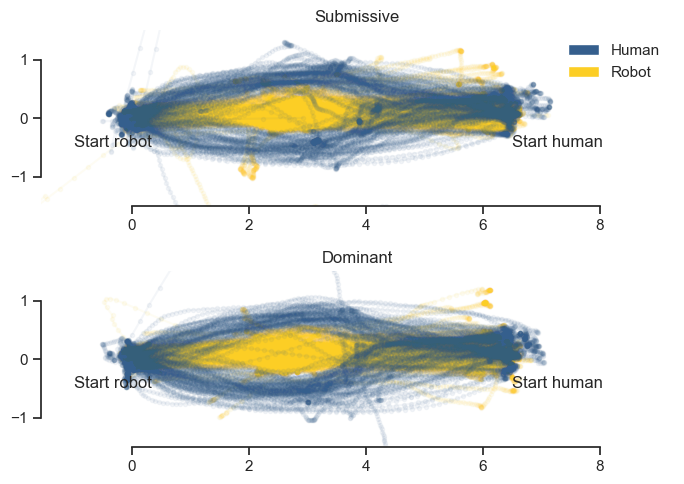

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(7,5)) 

starting_points = head_on_dynamics.groupby(["Participant", "trial"]).first().iloc[:,1:5].mean()

for ax, appearance in zip(axes, head_on_dynamics.Appearance.unique()):
    for traj_name, traj in head_on_dynamics[head_on_dynamics.Appearance==appearance].groupby(["Participant", "trial"]):
        ax.plot(traj.x_human, traj.z_human, color=human_color, marker=".", alpha=0.05, zorder=2)
        ax.plot(traj.x_spot, traj.z_spot, color=robot_color, marker=".", alpha=0.05, zorder=1)
    ax.axis("equal")
    ax.set_xlim([0.5, 7.2])
    ax.set_ylim([-1.5, 1.5])

    # ax.plot(starting_points.x_human, starting_points.z_human, ls="", marker="o", ms=10, color="k", zorder=300)
    ax.annotate(text="Start human", xy=(6.5, -0.5), xytext=(6.5, -0.5), textcoords="data", xycoords="data", zorder=3)

    # ax.plot(starting_points.x_spot, starting_points.z_spot, ls="", marker="s", ms=10, color="k", zorder=3)
    ax.annotate(text="Start robot", xy=(-0.5, -0.5), xytext=(-1, -0.5), textcoords="data", xycoords="data", zorder=3)

    ax.set_title(appearance)
    
    if appearance=="Submissive":
        legend_elements = [mpl_patches.Patch(facecolor=human_color, label="Human"), 
                           mpl_patches.Patch(facecolor=robot_color, label="Robot")]
        ax.legend(handles=legend_elements, frameon=False, loc="upper right")

plt.tight_layout()
sns.despine(trim=True)
plt.savefig("output/head_on_trajectories.png", bbox_inches="tight")

## Metrics: Getting metrics for each trajectory

In [12]:
def get_min_distance(traj):
    # print(traj.name)
    idx_min = traj.distance.idxmin()
    # print(idx_min)
    return pd.Series({"idx_min": idx_min,
                      "t_min": traj.loc[idx_min].time, 
                      "d_min": traj.loc[idx_min].distance}) 

In [13]:
distance_metrics = (head_on_dynamics.groupby(["Participant", "trial"])
                    .apply(get_min_distance)
                    .join(head_on_dynamics.groupby(["Participant", "trial"]).first()[["Appearance", "Experience"]])
                    .reset_index())

In [14]:
def get_crossing_data(pp_ids):
    data = None
    appearances = ['sub', 'dom']
    
    for appearance in appearances:
        trials = helper.get_trial_list('crossing', appearance)

        for pp_id in pp_ids:
            path_Human = 'data/traj_data/id_' + pp_id + '/Human'
            path_Spot = 'data/traj_data/id_' + pp_id + '/Spot'

            for i in trials[int(pp_id)-1]:
                df_Human = pd.read_csv(path_Human + "/" + pp_id + "_"+ str(i) + ".csv", header = 0, names=["x_human", "z_human", "time"])
                df_Spot = pd.read_csv(path_Spot +  "/" + pp_id + "_"+ str(i) + ".csv", header = 0, names=["x_spot", "z_spot", "time"])
                
                # Check if the length of the dataframe matchs
                if not df_Human.size == df_Spot.size: 
                    print("Warning: Time stamp does not match!!!")
                    break 

                if df_Human.z_human.iloc[0]>0:
                    df_Human.loc[:, "z_human"] *= -1
                    
                # Concatenate to one dataframe
                df = pd.concat([df_Human.loc[:, :"z_human"], df_Spot], axis=1)
                
                # Add some columns that can be useful later 
                df['trial'] = i
                df['Participant'] = int(pp_id)
                if appearance =='sub':
                    df['Appearance'] = 'Submissive'
                if appearance == 'dom':
                    df['Appearance'] = 'Dominant'

                data = pd.concat([data, df], axis = 0)
    
    return data

In [15]:
distance_metrics

,Participant,trial,idx_min,t_min,d_min,Appearance,Experience
0,1,1,28382.0,5.1,0.608186,Dominant,In-person
1,1,2,53.0,5.3,0.778055,Submissive,In-person
2,1,3,181.0,5.3,0.704137,Submissive,In-person
3,1,4,28593.0,6.1,0.930015,Dominant,In-person
4,1,5,267.0,5.7,0.745893,Submissive,In-person
...,...,...,...,...,...,...,...
330,21,12,57094.0,6.0,0.631903,Dominant,In-person
331,21,13,28028.0,5.6,0.769273,Submissive,In-person
332,21,14,57245.0,6.2,0.710637,Dominant,In-person
333,21,15,57438.0,5.9,0.699368,Dominant,In-person


## Metrics: Analyses

### Time of resolving the conflict: Plot

In [16]:
distance_metrics[distance_metrics.Appearance=="Dominant"].t_min.mean(), distance_metrics[distance_metrics.Appearance=="Submissive"].t_min.mean()

(6.482035928143713, 6.255952380952381)

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

<Axes: xlabel='Appearance', ylabel='t_min'>

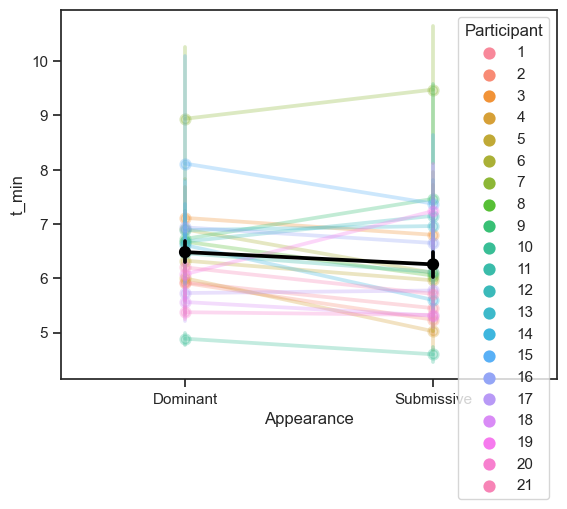

In [17]:
ax = sns.pointplot(data=distance_metrics, x="Appearance", y="t_min", hue="Participant")
plt.setp(ax.collections, alpha=.3, zorder=1) #for the markers
plt.setp(ax.lines, alpha=.3, zorder=1)
sns.pointplot(data=distance_metrics, x="Appearance", y="t_min", color="black", ax=ax)

### Conflict resolution time: Statistical model

In [19]:
model_t_min = pymer4.models.Lmer("t_min ~ Appearance + Experience + (1 | Participant) ", data=distance_metrics, family="gaussian")
model_t_min_fit = model_t_min.fit(factors={"Appearance": ["Submissive", "Dominant"], "Experience": ["In-person", "Videos"]})
print(model_t_min.coefs)

Linear mixed model fit by REML [’lmerMod’]
Formula: t_min~Appearance+Experience+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 335	 Groups: {'Participant': 21.0}

Log-likelihood: -541.045 	 AIC: 1092.089

Random effects:

                    Name    Var    Std
Participant  (Intercept)  0.895  0.946
Residual                  1.263  1.124

No random effect correlations specified

Fixed effects:

             Estimate    2.5_ci   97.5_ci        SE          DF     T-stat  \
(Intercept)  6.155635  5.560143  6.751128  0.303828   20.644615  20.260237   
Appearance1  0.222820 -0.017907  0.463548  0.122822  313.013656   1.814169   
Experience1  0.210666 -0.634593  1.055925  0.431262   19.005026   0.488487   

                    P-val  Sig  
(Intercept)  4.223418e-15  ***  
Appearance1  7.060897e-02    .  
Experience1  6.307940e-01       


D:\source\Spot-DataAnalysis\venv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


### Safety margin: plot

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

<Axes: xlabel='Appearance', ylabel='d_min'>

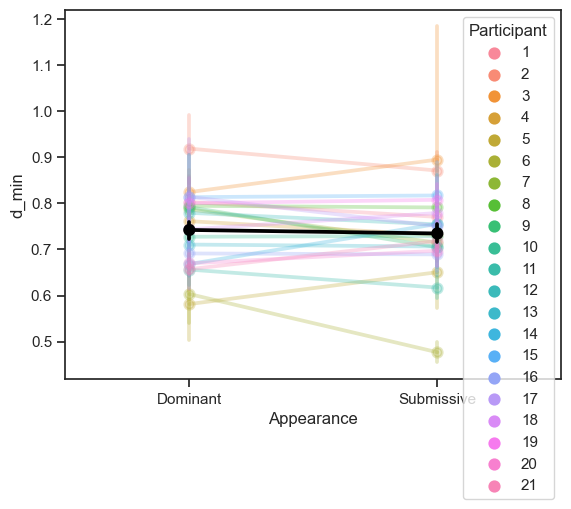

In [20]:
ax = sns.pointplot(data=distance_metrics, x="Appearance", y="d_min", hue="Participant")
plt.setp(ax.collections, alpha=.3, zorder=1) #for the markers
plt.setp(ax.lines, alpha=.3, zorder=1)
sns.pointplot(data=distance_metrics, x="Appearance", y="d_min", color="black", ax=ax)

### Safety margin: Statistical model

In [21]:
model_d_min = pymer4.models.Lmer("d_min ~ Appearance + Experience + (1 | Participant) ", data=distance_metrics, family="gaussian")
model_d_min_fit = model_d_min.fit(factors={"Appearance": ["Submissive", "Dominant"], "Experience": ["In-person", "Videos"]})
print(model_d_min.coefs)

Linear mixed model fit by REML [’lmerMod’]
Formula: d_min~Appearance+Experience+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 335	 Groups: {'Participant': 21.0}

Log-likelihood: 241.352 	 AIC: -472.705

Random effects:

                    Name    Var    Std
Participant  (Intercept)  0.006  0.079
Residual                  0.011  0.107

No random effect correlations specified

Fixed effects:

             Estimate    2.5_ci   97.5_ci        SE          DF     T-stat  \
(Intercept)  0.735214  0.684573  0.785854  0.025838   21.107470  28.455193   
Appearance1  0.007820 -0.015144  0.030784  0.011717  313.020980   0.667425   
Experience1 -0.001232 -0.072719  0.070255  0.036474   19.010017  -0.033766   

                    P-val  Sig  
(Intercept)  2.545687e-18  ***  
Appearance1  5.049923e-01       
Experience1  9.734156e-01       


D:\source\Spot-DataAnalysis\venv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


# Crossing scenario

In [22]:
crossing_dynamics = get_crossing_data(pp_ids=["%02d" % x for x in range(1, 22)])

In [23]:
crossing_dynamics

,x_human,z_human,x_spot,z_spot,time,trial,Participant,Appearance
0,3.163861,-2.849142,0.572392,0.234197,0.0,17,1,Submissive
1,3.169316,-2.846138,0.572304,0.234770,0.1,17,1,Submissive
2,3.174207,-2.843140,0.572807,0.234237,0.2,17,1,Submissive
3,3.179048,-2.839899,0.584498,0.238068,0.3,17,1,Submissive
4,3.182087,-2.837175,0.607149,0.243164,0.4,17,1,Submissive
...,...,...,...,...,...,...,...,...
167,3.358583,2.461900,6.206202,-0.056498,16.7,32,21,Dominant
168,3.359203,2.462352,6.206148,-0.056552,16.8,32,21,Dominant
169,3.357480,2.462551,6.206341,-0.056816,16.9,32,21,Dominant
170,3.357418,2.462553,6.205930,-0.056492,17.0,32,21,Dominant


### Preprocess the data

In [24]:
apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
groupby_cols = ["Participant", "trial"]
cols_to_smooth = ["x_human", "z_human", "x_spot", "z_spot"]
crossing_dynamics.loc[:, ["x_human", "z_human", "x_spot", "z_spot"]] = (crossing_dynamics.loc[:, groupby_cols + cols_to_smooth].groupby(groupby_cols).transform(apply_filter))
crossing_dynamics = crossing_dynamics.rename(columns={"pp_id": "Participant"})

participants = pd.read_csv("data/processed/participants.csv", index_col="Participant")
crossing_dynamics = crossing_dynamics.join(participants["Experience"], on="Participant", how="left")

mean_positions = crossing_dynamics.loc[crossing_dynamics["time"] == 0.0, ["x_human", "z_human", "x_spot", "z_spot"]].mean()
crossing_dynamics.loc[:, "distance_to_crossing_human"] = np.sqrt((crossing_dynamics.x_human - mean_positions.x_human)**2 + (crossing_dynamics.z_human - mean_positions.z_spot)**2)
crossing_dynamics.loc[:, "distance_to_crossing_robot"] = np.sqrt((crossing_dynamics.x_spot - mean_positions.x_human)**2 + (crossing_dynamics.z_spot - mean_positions.z_spot)**2)

In [25]:
crossing_dynamics.to_csv("data/processed/crossing_dynamics_processed.csv", index=False)

## Reading the preprocessed data

In [26]:
crossing_dynamics = pd.read_csv("data/processed/crossing_dynamics_processed.csv")

In [27]:
crossing_dynamics

,x_human,z_human,x_spot,z_spot,time,trial,Participant,Appearance,Experience,distance_to_crossing_human,distance_to_crossing_robot
0,3.169588,-2.825932,0.534783,0.238298,0.0,17,1,Submissive,In-person,2.932536,2.716863
1,3.174139,-2.833898,0.554903,0.238933,0.1,17,1,Submissive,In-person,2.940381,2.696798
2,3.177770,-2.840314,0.577801,0.239529,0.2,17,1,Submissive,In-person,2.946705,2.673958
3,3.180480,-2.845178,0.603476,0.240087,0.3,17,1,Submissive,In-person,2.951505,2.648344
4,3.182269,-2.848492,0.631929,0.240606,0.4,17,1,Submissive,In-person,2.954777,2.619954
...,...,...,...,...,...,...,...,...,...,...,...
56150,3.357803,2.462269,6.206129,-0.056745,16.7,32,21,Dominant,In-person,2.359262,2.962178
56151,3.358232,2.462352,6.206238,-0.056738,16.8,32,21,Dominant,In-person,2.359365,2.962286
56152,3.358651,2.462487,6.206375,-0.056713,16.9,32,21,Dominant,In-person,2.359520,2.962422
56153,3.359060,2.462675,6.206541,-0.056671,17.0,32,21,Dominant,In-person,2.359726,2.962586


##  Walking trajectories 

### Starting and final positions

In [28]:
starting_positions = crossing_dynamics.groupby(["Participant", "trial"]).first()
final_positions = crossing_dynamics.groupby(["Participant", "trial"]).last()

In [29]:
mean_positions

x_human    3.248400
z_human   -2.573512
x_spot     0.388923
z_spot     0.105545
dtype: float64

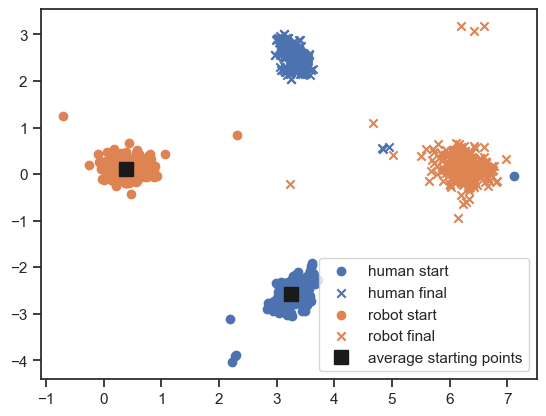

In [30]:
fig, ax = plt.subplots()
ax.scatter(starting_positions.x_human, starting_positions.z_human, color="C0", marker="o", label="human start")
ax.scatter(final_positions.x_human, final_positions.z_human, color="C0", marker="x", label="human final")
ax.scatter(starting_positions.x_spot, starting_positions.z_spot, color="C1", marker="o", label="robot start")
ax.scatter(final_positions.x_spot, final_positions.z_spot, color="C1", marker="x", label="robot final")
ax.plot(mean_positions.x_human, mean_positions.z_human, color="k", ls="", marker="s", ms=10, label="average starting points")
ax.plot(mean_positions.x_spot, mean_positions.z_spot, color="k", marker="s", ms=10)
ax.legend()

### All trajectories

In [31]:
crossing_dynamics

,x_human,z_human,x_spot,z_spot,time,trial,Participant,Appearance,Experience,distance_to_crossing_human,distance_to_crossing_robot
0,3.169588,-2.825932,0.534783,0.238298,0.0,17,1,Submissive,In-person,2.932536,2.716863
1,3.174139,-2.833898,0.554903,0.238933,0.1,17,1,Submissive,In-person,2.940381,2.696798
2,3.177770,-2.840314,0.577801,0.239529,0.2,17,1,Submissive,In-person,2.946705,2.673958
3,3.180480,-2.845178,0.603476,0.240087,0.3,17,1,Submissive,In-person,2.951505,2.648344
4,3.182269,-2.848492,0.631929,0.240606,0.4,17,1,Submissive,In-person,2.954777,2.619954
...,...,...,...,...,...,...,...,...,...,...,...
56150,3.357803,2.462269,6.206129,-0.056745,16.7,32,21,Dominant,In-person,2.359262,2.962178
56151,3.358232,2.462352,6.206238,-0.056738,16.8,32,21,Dominant,In-person,2.359365,2.962286
56152,3.358651,2.462487,6.206375,-0.056713,16.9,32,21,Dominant,In-person,2.359520,2.962422
56153,3.359060,2.462675,6.206541,-0.056671,17.0,32,21,Dominant,In-person,2.359726,2.962586


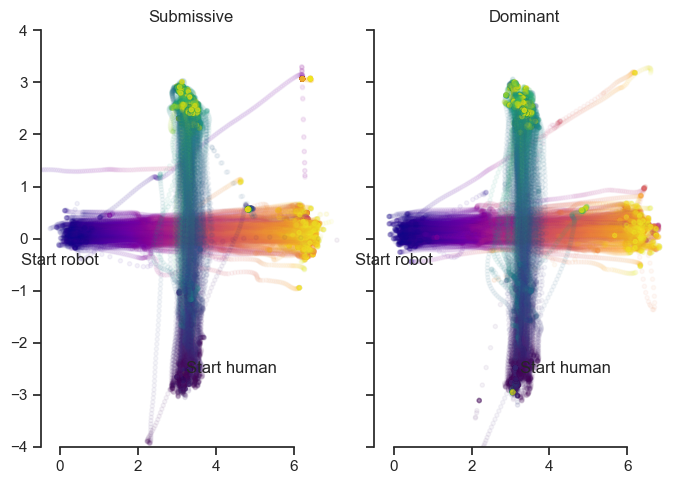

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(7,5), sharex=True, sharey=True) 

starting_points = crossing_dynamics.groupby(["Participant", "trial"]).first().iloc[:,0:4].mean()

for ax, appearance in zip(axes, crossing_dynamics.Appearance.unique()):
    for traj_name, traj in crossing_dynamics[crossing_dynamics.Appearance==appearance].groupby(["Participant", "trial"]):
        ax.scatter(traj.x_human, traj.z_human, c=cm.viridis(traj.time/traj.time.max()), marker=".", alpha=0.05, zorder=2)
        ax.scatter(traj.x_spot, traj.z_spot, c=cm.plasma(traj.time/traj.time.max()), marker=".", alpha=0.05, zorder=1)
    # ax.axis("equal")
    ax.set_xlim([-0.5, 7.2])
    ax.set_ylim([-4, 4])

    ax.annotate(text="Start human", xy=starting_points[["x_human", "z_human"]], xytext=starting_points[["x_human", "z_human"]], textcoords="data", xycoords="data", zorder=3)

    ax.annotate(text="Start robot", xy=(-0.5, -0.5), xytext=(-1, -0.5), textcoords="data", xycoords="data", zorder=3)

    ax.set_title(appearance)

plt.tight_layout()
sns.despine(trim=True)
plt.savefig("output/crossing_trajectories.png")

## Getting the metrics

In [33]:
def get_t_crossing(traj):
    idx_min_human = traj.distance_to_crossing_human.idxmin()
    idx_min_robot = traj.distance_to_crossing_robot.idxmin()
    return pd.Series({"idx_min_human": idx_min_human,
                      "idx_min_robot": idx_min_robot,
                      "t_crossing_human": traj.loc[idx_min_human].time, 
                      "t_crossing_robot": traj.loc[idx_min_robot].time})

crossing_metrics = (crossing_dynamics.groupby(["Participant", "trial"])
                    .apply(get_t_crossing)
                    .join(crossing_dynamics.groupby(["Participant", "trial"]).first()[["Appearance", "Experience"]])
                    .reset_index())

In [34]:
crossing_metrics["is_human_first"] = crossing_metrics["t_crossing_human"] < crossing_metrics["t_crossing_robot"]
crossing_metrics["crossed_first"] = "robot"
crossing_metrics.loc[crossing_metrics.is_human_first, ["crossed_first"]] = "human"

In [35]:
crossing_metrics

,Participant,trial,idx_min_human,idx_min_robot,t_crossing_human,t_crossing_robot,Appearance,Experience,is_human_first,crossed_first
0,1,17,79.0,55.0,7.9,5.5,Submissive,In-person,False,robot
1,1,18,27910.0,27940.0,4.3,7.3,Dominant,In-person,True,human
2,1,19,28080.0,28105.0,4.0,6.5,Dominant,In-person,True,human
3,1,20,256.0,284.0,3.9,6.7,Submissive,In-person,True,human
4,1,21,418.0,397.0,7.5,5.4,Submissive,In-person,False,robot
...,...,...,...,...,...,...,...,...,...,...
330,21,28,27454.0,27480.0,4.4,7.0,Submissive,In-person,True,human
331,21,29,55871.0,55903.0,4.4,7.6,Dominant,In-person,True,human
332,21,30,27601.0,27624.0,4.5,6.8,Submissive,In-person,True,human
333,21,31,27748.0,27777.0,4.3,7.2,Submissive,In-person,True,human


## Who crossed first: Plots

In [36]:
crossing_metrics.crossed_first.value_counts()/len(crossing_metrics)#").value_count#/crossing_metrics.size

crossed_first
human    0.814925
robot    0.185075
Name: count, dtype: float64

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

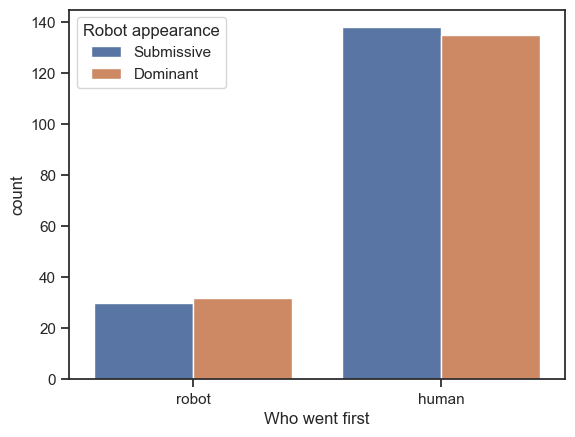

In [37]:
fig, ax = plt.subplots()
g = sns.countplot(data=crossing_metrics, x="crossed_first", hue="Appearance", ax=ax)
ax.set_xlabel("Who went first")
g.legend().set_title("Robot appearance")
# g.legend.set_title("TTA")

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

Text(0, 0.5, '% human went first')

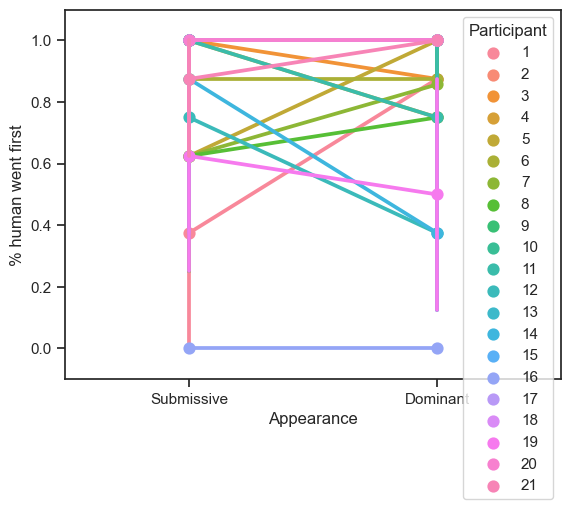

In [38]:
fig, ax = plt.subplots()
sns.pointplot(data=crossing_metrics, y="is_human_first", x="Appearance", hue="Participant", ax=ax)
ax.set_ylim((-0.1,1.1))
ax.set_ylabel("% human went first")

## Who crossed first: statistical model

In [39]:
model_is_human_first = pymer4.models.Lmer("is_human_first ~ Appearance + Experience + (1 | Participant) ", data=crossing_metrics, family="binomial")
model_is_go_decision_fit = model_is_human_first.fit(factors={"Appearance": ["Submissive", "Dominant"], "Experience": ["In-person", "Videos"]})
print(model_is_human_first.coefs)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: is_human_first~Appearance+Experience+(1|Participant)

Family: binomial	 Inference: parametric

Number of observations: 335	 Groups: {'Participant': 21.0}

Log-likelihood: -124.303 	 AIC: 256.606

Random effects:

                    Name    Var    Std
Participant  (Intercept)  4.889  2.211

No random effect correlations specified

Fixed effects:

             Estimate    2.5_ci   97.5_ci        SE        OR  OR_2.5_ci  \
(Intercept)  2.045491  0.551892  3.539090  0.762054  7.732952   1.736535   
Appearance1 -0.136456 -0.818599  0.545687  0.348039  0.872445   0.441049   
Experience1  1.126110 -1.159190  3.411411  1.165991  3.083639   0.313740   

             OR_97.5_ci      Prob  Prob_2.5_ci  Prob_97.5_ci    Z-stat  \
(Intercept)   34.435560  0.885491     0.634574      0.971780  2.684180   
Appearance1    1.725794  0.465939     0.306061      0.633134 -0.392071   
Experience1   30.307971  0.755120     0.238815      0.968

D:\source\Spot-DataAnalysis\venv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


## Distance dynamics

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

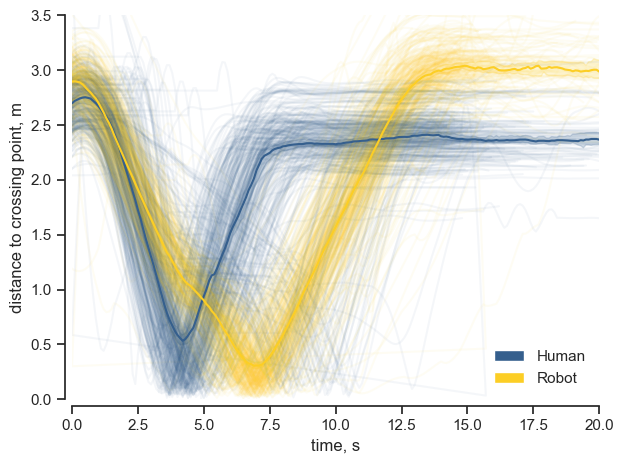

In [40]:
fig, ax = plt.subplots()
for name, traj in crossing_dynamics.groupby(["Participant", "trial"]):
    # appearance = traj.Appearance.iloc[0]
    ax.plot(traj.time, traj.distance_to_crossing_human, color=human_color, alpha=0.05)
    ax.plot(traj.time, traj.distance_to_crossing_robot, color=robot_color, alpha=0.05)
ax.set_xlim((0, 20))
sns.lineplot(data=crossing_dynamics, x='time', y='distance_to_crossing_human', color=human_color, estimator=np.median, ax=ax)
sns.lineplot(data=crossing_dynamics, x='time', y='distance_to_crossing_robot', color=robot_color, estimator=np.median, ax=ax)

legend_elements = [mpl_patches.Patch(facecolor=human_color, label="Human"), 
                   mpl_patches.Patch(facecolor=robot_color, label="Robot")]
ax.legend(handles=legend_elements, frameon=False, loc="lower right")

ax.set_ylim((0, 3.5))
ax.set_xlabel("time, s")
ax.set_ylabel("distance to crossing point, m")
sns.despine(offset=5, trim=True)
plt.tight_layout()
plt.savefig("output/crossing_distance.png", bbox_inches="tight")

## Differences in trajectories depending on robot appearance

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

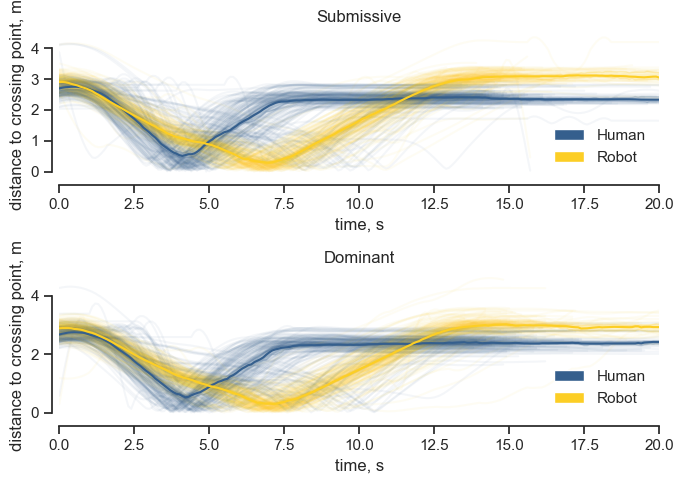

In [41]:
fig, axes = plt.subplots(2, 1, figsize=(7,5))
for appearance, ax in zip(crossing_dynamics.Appearance.unique(), axes):
    trajectories_to_plot = crossing_dynamics[crossing_dynamics.Appearance==appearance]
    for name, traj in trajectories_to_plot.groupby(["Participant", "trial"]):
        # appearance = traj.Appearance.iloc[0]
        ax.plot(traj.time, traj.distance_to_crossing_human, color=human_color, alpha=0.05)
        ax.plot(traj.time, traj.distance_to_crossing_robot, color=robot_color, alpha=0.05)
    ax.set_xlim((0, 20))
    sns.lineplot(data=trajectories_to_plot, x='time', y='distance_to_crossing_human', color=human_color, estimator=np.median, ax=ax)
    sns.lineplot(data=trajectories_to_plot, x='time', y='distance_to_crossing_robot', color=robot_color, estimator=np.median, ax=ax)
    
    legend_elements = [mpl_patches.Patch(facecolor=human_color, label="Human"), 
                       mpl_patches.Patch(facecolor=robot_color, label="Robot")]
    ax.legend(handles=legend_elements, frameon=False, loc="lower right")
    
    # ax.set_ylim()
    ax.set_xlabel("time, s")
    ax.set_ylabel("distance to crossing point, m")
    ax.set_title(appearance)
    
sns.despine(offset=5, trim=True)
plt.tight_layout()
plt.savefig("output/crossing_distance_by_appearance.png", bbox_inches="tight")